In [1]:
import pandas as pd
# Считывание данных
path='D:/Anna/магистратура доки/ИТМО/ai/transaction_fraud_data.parquet'
df=pd.read_parquet(path)

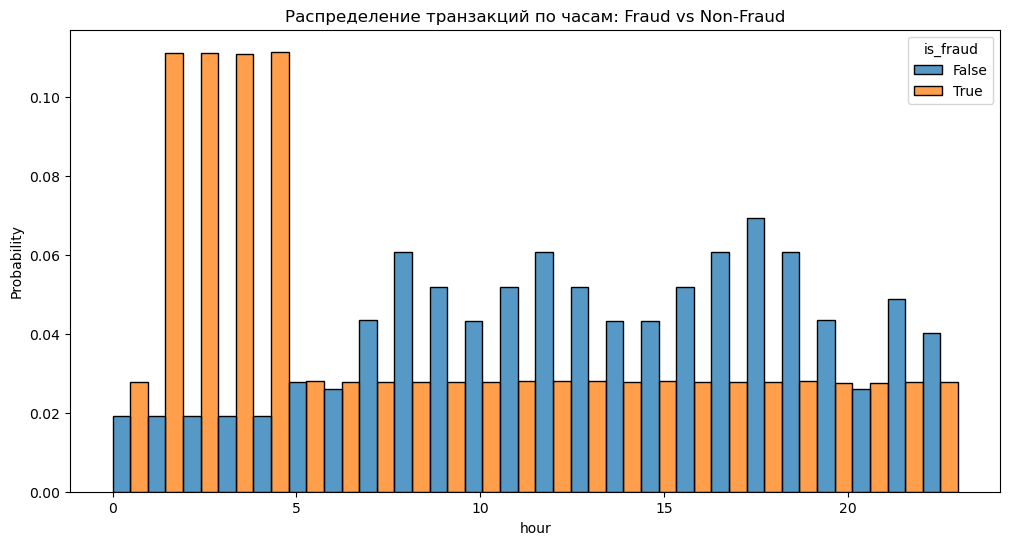

Хи-квадрат тест: p-value = 0.0000e+00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

# Гипотеза 1. Мошеннические транзакции происходят во время, отличное от легальных транзакций
df['hour'] = df['timestamp'].dt.hour
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='hour', hue='is_fraud', bins=24, multiple='dodge', stat='probability', common_norm=False)
plt.title('Распределение транзакций по часам: Fraud vs Non-Fraud')
plt.show()

# Тест хи-квадрат
contingency_table = pd.crosstab(df['hour'], df['is_fraud'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f'Хи-квадрат тест: p-value = {p:.4e}') # Значение p-value < 0.05 - есть зависимость часа суток и тем, что транзакция мошенническая

In [7]:
# Гипотеза 2. Мошеннические транзакции происходят с меньшим временным интервалом
df_sorted = df.sort_values(['customer_id', 'timestamp'])
df_sorted['time_diff'] = df_sorted.groupby('customer_id')['timestamp'].diff().dt.total_seconds() / 60  # в минутах

fraud_time_diff = df_sorted[df_sorted['is_fraud']]['time_diff'].dropna()
non_fraud_time_diff = df_sorted[~df_sorted['is_fraud']]['time_diff'].dropna()

# U-тест
u_stat, p_value = stats.mannwhitneyu(fraud_time_diff, non_fraud_time_diff, alternative='less')
print(f'U-тест: p-value = {p_value}') # Значение p-value > 0.05 - особой разницы во временных промежутках между транзакциями нет

U-тест: p-value = 1.0


In [9]:
# Гипотеза 3. Есть типы карт, которые более устойчивы к мошенническим операциям
card_type_fraud = df.groupby('card_type')['is_fraud'].mean().sort_values(ascending=False)
print('Доля мошенничества по типам карт:',card_type_fraud)

# Тест хи-квадрат
contingency_table = pd.crosstab(df['card_type'], df['is_fraud'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f'Хи-квадрат тест для типов карт: p-value = {p:4f}') # Значение p-value > 0.05 - особой разницы во типах карт нет

Доля мошенничества по типам карт: card_type
Basic Credit       0.199742
Platinum Credit    0.199731
Gold Credit        0.199729
Premium Debit      0.199721
Basic Debit        0.199720
Name: is_fraud, dtype: float64
Хи-квадрат тест для типов карт: p-value = 0.999999


Доля мошенничества по каналам:
channel
pos       1.000000
mobile    0.123878
web       0.123275
Name: is_fraud, dtype: float64


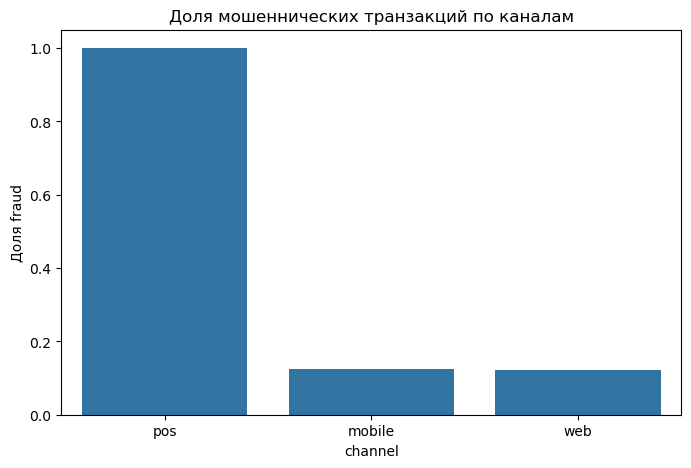

Хи-квадрат тест для каналов: p-value = 0.000e+00


In [11]:
# Гипотеза 4. Между мошенническими транзакциями и каналами есть взаимосвязь
channel_fraud = df.groupby('channel')['is_fraud'].mean().sort_values(ascending=False)
print('Доля мошенничества по каналам:')
print(channel_fraud)

plt.figure(figsize=(8, 5))
sns.barplot(x=channel_fraud.index, y=channel_fraud.values)
plt.title('Доля мошеннических транзакций по каналам')
plt.ylabel('Доля fraud')
plt.show()

# Тест хи-квадрат
contingency_table = pd.crosstab(df['channel'], df['is_fraud'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f'Хи-квадрат тест для каналов: p-value = {p:.3e}') # Значение p-value < 0.05 - есть зависимость 

In [13]:
# Выделение топа девайсов для каждого канала
channels_of_interest = ['mobile', 'web', 'pos'] 
filtered_df = df[df['channel'].isin(channels_of_interest)]

result = (filtered_df.groupby(['channel', 'device'])
          .agg(
              total_transactions=('is_fraud', 'count'),
              fraud_count=('is_fraud', 'sum')
          )
          .assign(
              fraud_rate=lambda x: x['fraud_count'] / x['total_transactions']
          )
          .reset_index()
          .sort_values(['channel', 'fraud_count'], ascending=[True, False])
          )

result['fraud_rate'] = result['fraud_rate'].apply(lambda x: f"{x:.2%}")

def print_top_devices(channel_name, n=10):
    print(f'\nТоп {n} устройств для канала "{channel_name}":')
    channel_data = result[result['channel'] == channel_name].head(n)
    print(channel_data[['device', 'fraud_count', 'total_transactions', 'fraud_rate']]
          .to_string(index=False))

for channel in channels_of_interest:
    print_top_devices(channel)


Топ 10 устройств для канала "mobile":
     device  fraud_count  total_transactions fraud_rate
Android App       140844             1126117     12.51%
    iOS App       140306             1143461     12.27%

Топ 10 устройств для канала "web":
 device  fraud_count  total_transactions fraud_rate
Firefox       142171             1120952     12.68%
 Safari       141379             1120245     12.62%
 Chrome       140087             1132384     12.37%
   Edge       138885             1189560     11.68%

Топ 10 устройств для канала "pos":
         device  fraud_count  total_transactions fraud_rate
    Chip Reader       217324              217324    100.00%
Magnetic Stripe       217204              217204    100.00%
    NFC Payment       216519              216519    100.00%


In [15]:
from statsmodels.stats.proportion import proportions_ztest

# Гипотеза 5. Вендоры с более высоким риском чаще имеют мошеннические операции
risk_fraud = df.groupby('is_high_risk_vendor')['is_fraud'].mean()
print('Доля fraud по уровню риска вендора:')
print(risk_fraud)

# Хи-квадрат тест
contingency_table = pd.crosstab(df['is_high_risk_vendor'], df['is_fraud'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f'Хи-квадрат тест: p-value = {p}') # Значение p-value > 0.05 - зависимости нет

Доля fraud по уровню риска вендора:
is_high_risk_vendor
False    0.199642
True     0.199986
Name: is_fraud, dtype: float64
Хи-квадрат тест: p-value = 0.3081474689971894


In [17]:
# Выделим наиболее подозрительных вендоров
vendor_fraud = df.groupby('vendor')['is_fraud'].agg(['sum', 'count', 'mean'])
vendor_fraud = vendor_fraud.rename(columns={'sum': 'fraud_count', 
                                           'count': 'total_transactions', 
                                           'mean': 'fraud_rate'})
# p-value для каждого вендора
overall_fraud_rate = df['is_fraud'].mean()
p_values = []

for vendor in vendor_fraud.index:
    fraud_count = vendor_fraud.loc[vendor, 'fraud_count']
    total = vendor_fraud.loc[vendor, 'total_transactions']
    
    if total > 0:
        stat, p_val = proportions_ztest(
            count=fraud_count,
            nobs=total,
            value=overall_fraud_rate,
            alternative='larger'
        )
    else:
        p_val = 1.0 
    
    p_values.append(p_val)

vendor_fraud['p-value'] = p_values

high_risk_vendors = vendor_fraud[vendor_fraud['fraud_rate'] > vendor_fraud['fraud_rate'].quantile(0.95)]
print('Подозрительные вендоры:')
print(high_risk_vendors)

Подозрительные вендоры:
                 fraud_count  total_transactions  fraud_rate   p-value
vendor                                                                
JetBlue                 7883               38934    0.202471  0.089033
McDonald's             10505               51927    0.202303  0.072049
Publix                 13639               67095    0.203279  0.011144
StubHub                12710               62696    0.202724  0.031020
Uber                    9497               46700    0.203362  0.025533
United Airlines         8005               39226    0.204074  0.016358


Таблица сопряженности:
                         fraud_count  total_transactions  fraud_rate
is_outside_home_country                                             
False                         126343             5073605    0.024902
True                         1368376             2410161    0.567753
Результат Z-теста: p-value = 0.0


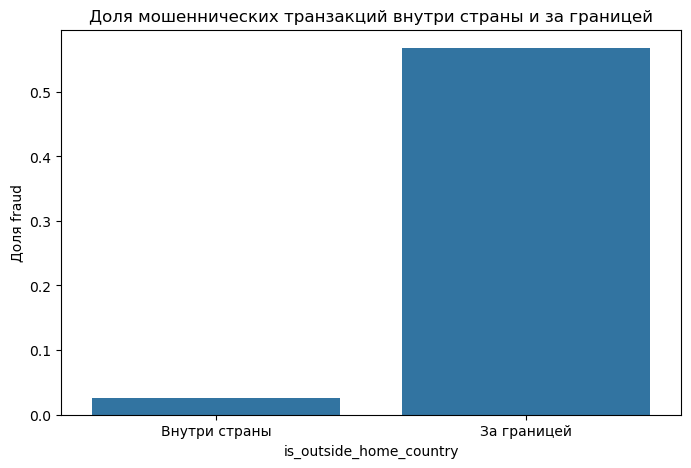

In [19]:
# Гипотеза 6. Из-за границы происходит больше мошеннических транзакций
grouped = df.groupby('is_outside_home_country')['is_fraud'].agg(['sum', 'count'])
grouped = grouped.rename(columns={'sum': 'fraud_count', 
                                  'count': 'total_transactions' 
                                           })
grouped['fraud_rate']=grouped['fraud_count']/grouped['total_transactions']
print("Таблица сопряженности:")
print(grouped)

# Используем Z-тест
counts = grouped['fraud_count'].values
nobs = grouped['total_transactions'].values 

stat, p_value = proportions_ztest(counts, nobs,alternative='smaller')
print(f'Результат Z-теста: p-value = {p_value}') # Значение p-value < 0.05 - из-за границы больше мошеннических транзакций 

plt.figure(figsize=(8, 5))
sns.barplot(
    x=grouped.index.map({True: 'За границей', False: 'Внутри страны'}), 
    y=grouped['fraud_count'] / grouped['total_transactions'],
)
plt.title('Доля мошеннических транзакций внутри страны и за границей')
plt.ylabel('Доля fraud')
plt.show()

In [112]:
# Бинарный классификатор для предсказания мошеннической транзакции
from sklearn.model_selection import train_test_split

df['is_foreign'] = df['is_outside_home_country'].astype(int)
df['is_high_risk'] = df['is_high_risk_vendor'].astype(int)

features = [
    'amount', 'hour', 'is_foreign',
    'is_high_risk', 'channel', 'card_type'
]
X = df[features]
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
# Преобразование категориальных переменных
X_train['channel'] = X_train['channel'].astype('category').cat.codes
X_train['card_type'] = X_train['card_type'].astype('category').cat.codes

X_test['channel'] = X_test['channel'].astype('category').cat.codes
X_test['card_type'] = X_test['card_type'].astype('category').cat.codes

In [116]:
# Обучение модели
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    max_depth=8,
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_jobs=-1,
                       random_state=42)

In [118]:
#Оценка качества
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print('Classification Report:')
print(classification_report(y_test, y_pred))
print(f'\nROC-AUC: {roc_auc_score(y_test, y_proba):.4f}')

Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.89      0.94   1197810
        True       0.69      0.93      0.79    298944

    accuracy                           0.90   1496754
   macro avg       0.84      0.91      0.86   1496754
weighted avg       0.92      0.90      0.91   1496754


ROC-AUC: 0.9712
